# Product Segmentation Case Study

## Context

When you think of sneakers for a trip, the importance of good footwear cannot be discarded, and the obvious brands that come to mind are Adidas and Nike. Adidas vs Nike is a constant debate as the two giants in the apparel market, with a large market cap and market share, battle it out to come on top. As a newly hired Data Scientist in a market research company, you have been given the task of extracting insights from the data of men's and women's shoes, and grouping products together to identify similarities and differences between the product range of these renowned brands.

## Objective

To perform an exploratory data analysis and cluster the products based on various factors


## Key Questions

- Which variables are most important for clustering?
- How each cluster is different from the others?
- What are the business recommendations?


## Data Description

The dataset consists of 3268 products from Nike and Adidas with features of information including their ratings, discount, sales price, listed price, product name, and the number of reviews.

- Product Name: Name of the product
- Product ID: ID of the product
- Listing Price: Listed price of the product
- Sale Price: Sale price of the product
- Discount: Percentage of discount on the product
- Brand: Brand of the product
- Rating: Rating of the product
- Reviews: Number of reviews for the product

## Let's start coding!

### Importing necessary libraries

In [1]:
# please uncomment and run the next line if yellowbrick library is not previously installed
!pip install yellowbrick

In [2]:
# this will help in making the Python code more structured automatically (good coding practice)
#load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# loading the dataset
data = pd.read_csv('/content/drive/My Drive/project/data_add_nik.csv')

In [5]:
data.shape

(3268, 8)

* The dataset has 3268 rows and 8 columns

In [6]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Rating,Reviews
255,Women's adidas Originals POD-S3.1 Shoes,CG6188,13999,6999,50,Adidas ORIGINALS,3.3,8
1551,Men's adidas Originals Superstar Pure Shoes,FV3013,11999,11999,0,Adidas ORIGINALS,3.9,10
1352,Men's adidas Originals Superstar Shoes,FV2806,7999,7999,0,Adidas ORIGINALS,4.4,42
1060,Men's adidas Football Nemeziz 19.3 Indoor Shoes,F34411,5999,3599,40,Adidas SPORT PERFORMANCE,4.5,75
808,Men's adidas Sport Inspired Court 80s Shoes,EE9676,5999,3599,40,Adidas CORE / NEO,4.5,55
836,Men's adidas Running Stargon 1.0 Shoes,CM4935,4799,3839,20,Adidas CORE / NEO,3.5,21
2107,Men's adidas Originals Yung-96 Chasm Shoes,EE7238,7999,4799,40,Adidas ORIGINALS,3.0,62
3002,Nike SB Air Max Stefan Janoski 2,AQ7477-009,0,9995,0,Nike,2.6,11
2329,Men's adidas Originals Rivalry Low Shoes,FV4287,10999,10999,0,Adidas ORIGINALS,2.8,8
602,Men's adidas Sport Inspired Lite Racer RBN Shoes,F36642,5599,3919,30,Adidas CORE / NEO,3.0,56


In [7]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [8]:
# fixing column names
df.columns = [c.replace(" ", "_") for c in df.columns]

In [9]:
# let's look at the structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product_Name   3268 non-null   object 
 1   Product_ID     3268 non-null   object 
 2   Listing_Price  3268 non-null   int64  
 3   Sale_Price     3268 non-null   int64  
 4   Discount       3268 non-null   int64  
 5   Brand          3268 non-null   object 
 6   Rating         3268 non-null   float64
 7   Reviews        3268 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 204.4+ KB


**We won't need Product_ID for analysis, so let's drop this column.**

In [10]:
df.drop("Product_ID", axis=1, inplace=True)

In [11]:
# let's check for duplicate observations
df.duplicated().sum()

117

- There are 117 duplicate observations. We will remove them from the data.

In [12]:
df = df[(~df.duplicated())].copy()

**Let's take a look at the summary of the data**

In [13]:
df.describe()

,Listing_Price,Sale_Price,Discount,Rating,Reviews
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000
mean,7045.960330,5983.166931,27.860997,3.285687,41.891146
std,4652.089511,4173.708897,22.442753,1.371611,31.283464
min,0.000000,449.000000,0.000000,0.000000,0.000000
25%,4599.000000,2999.000000,0.000000,2.600000,12.000000
50%,5999.000000,4599.000000,40.000000,3.600000,40.000000
75%,8999.000000,7799.000000,50.000000,4.400000,69.000000
max,29999.000000,36500.000000,60.000000,5.000000,223.000000


**Observations**

- 0 in the listing price indicates missing values.
- The average listing price is 7046.
- The average sale price is 5983.
- The average discount is 28%.
- The average rating is 3.3.
- The average number of reviews is 42.

In [14]:
# let's check how many products have listing price 0
(df.Listing_Price == 0).sum()

336

In [15]:
# let's check the products which have listing price 0
df[(df.Listing_Price == 0)]

,Product_Name,Listing_Price,Sale_Price,Discount,Brand,Rating,Reviews
2625,Nike Air Force 1 '07 Essential,0,7495,0,Nike,0.0,0
2626,Nike Air Force 1 '07,0,7495,0,Nike,0.0,0
2627,Nike Air Force 1 Sage Low LX,0,9995,0,Nike,0.0,0
2628,Nike Air Max Dia SE,0,9995,0,Nike,0.0,0
2629,Nike Air Max Verona,0,9995,0,Nike,0.0,0
...,...,...,...,...,...,...,...
3254,Nike Mercurial Vapor 13 Club MG,0,4995,0,Nike,0.0,0
3257,Air Jordan 5 Retro,0,15995,0,Nike,3.3,3
3260,Nike Tiempo Legend 8 Academy TF,0,6495,0,Nike,0.0,0
3262,Nike React Metcon AMP,0,13995,0,Nike,3.0,1


In [16]:
df[(df.Listing_Price == 0)].describe()

,Listing_Price,Sale_Price,Discount,Rating,Reviews
count,336.0,336.000000,336.0,336.000000,336.000000
mean,0.0,11203.050595,0.0,2.797619,8.261905
std,0.0,4623.825788,0.0,2.150445,19.708393
min,0.0,1595.000000,0.0,0.000000,0.000000
25%,0.0,7995.000000,0.0,0.000000,0.000000
50%,0.0,10995.000000,0.0,3.950000,1.000000
75%,0.0,13995.000000,0.0,4.700000,6.000000
max,0.0,36500.000000,0.0,5.000000,223.000000


- There are 336 observations that have missing values in the listing price column
- We see that the discount for the products with listing price 0 is 0.
- So, we will replace the listing price with the corresponding sale price for those observations.

In [17]:
df.loc[(df.Listing_Price == 0), ["Listing_Price"]] = df.loc[
    (df.Listing_Price == 0), ["Sale_Price"]
].values

In [18]:
df.Listing_Price.describe()

count     3151.000000
mean      8240.573151
std       4363.018245
min        899.000000
25%       4999.000000
50%       7599.000000
75%      10995.000000
max      36500.000000
Name: Listing_Price, dtype: float64

In [19]:
# checking missing values
df.isna().sum()

Product_Name     0
Listing_Price    0
Sale_Price       0
Discount         0
Brand            0
Rating           0
Reviews          0
dtype: int64

- There are no missing values in the data.

## EDA

In [20]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

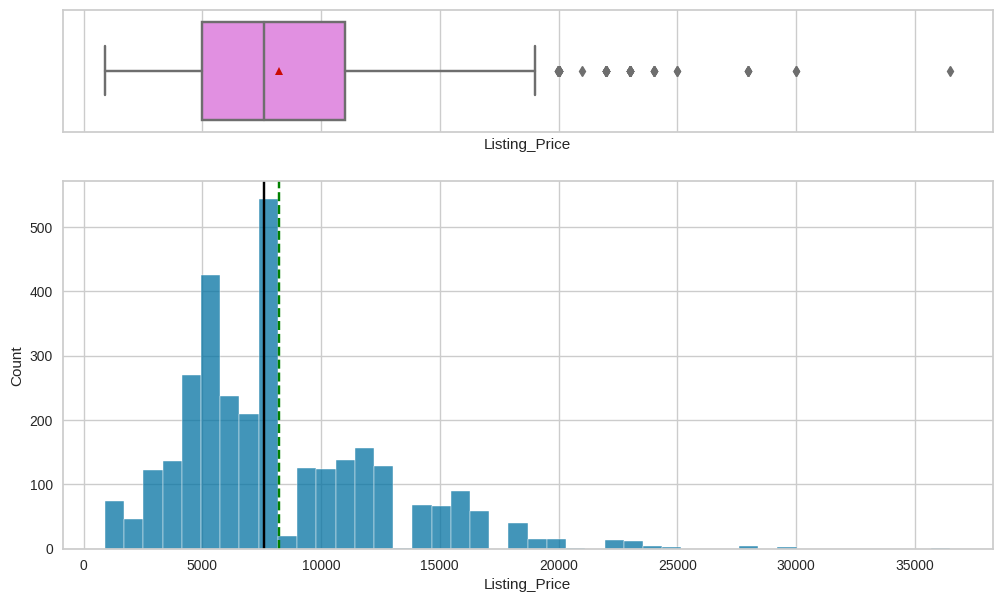

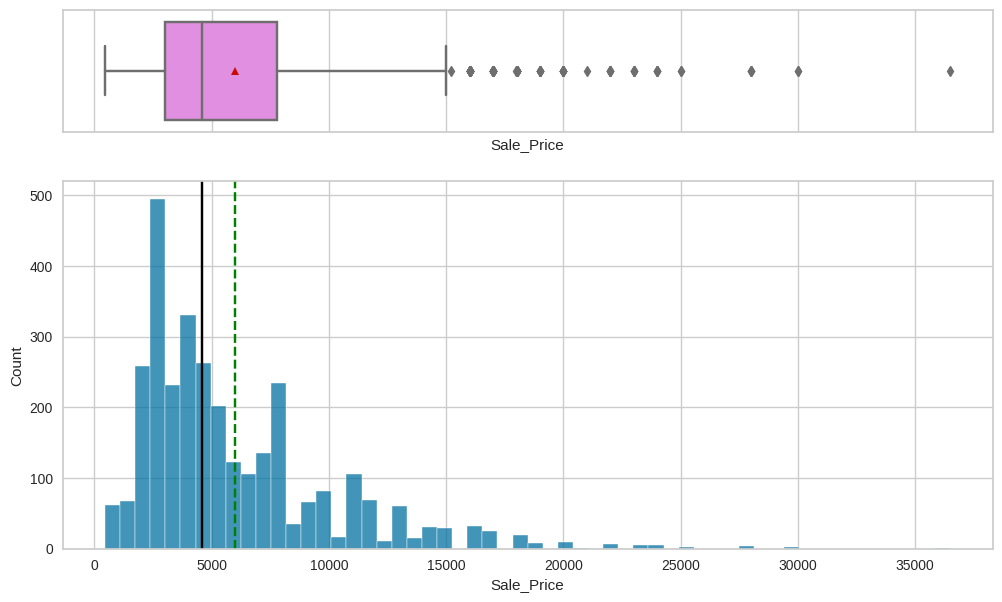

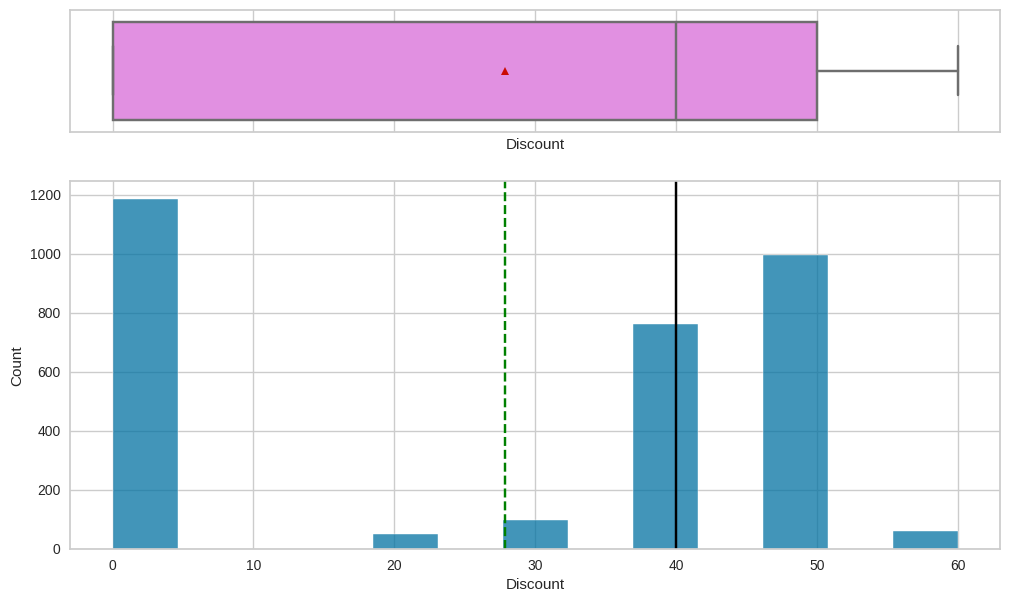

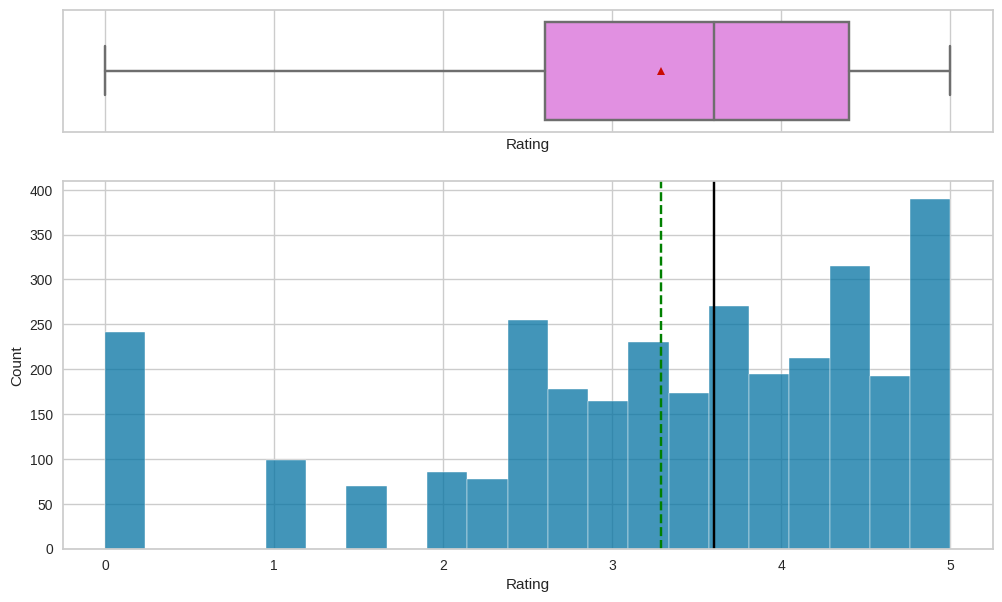

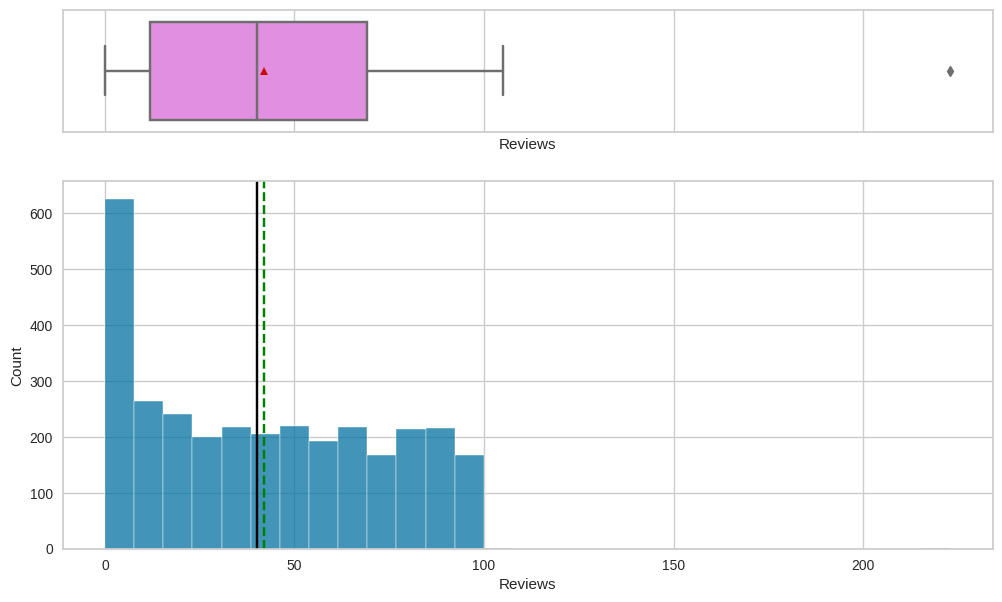

In [21]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

**Observations**

- Listing price and sale price have right-skewed distributions with upper outliers, which indicates the presence of very expensive products.
- The maximum discount given is 60%.
- Rating is left-skewed and most of the ratings are between 2.5 and 4.5.
- The number of reviews is between 1 and 100, with an outlier value above 200.

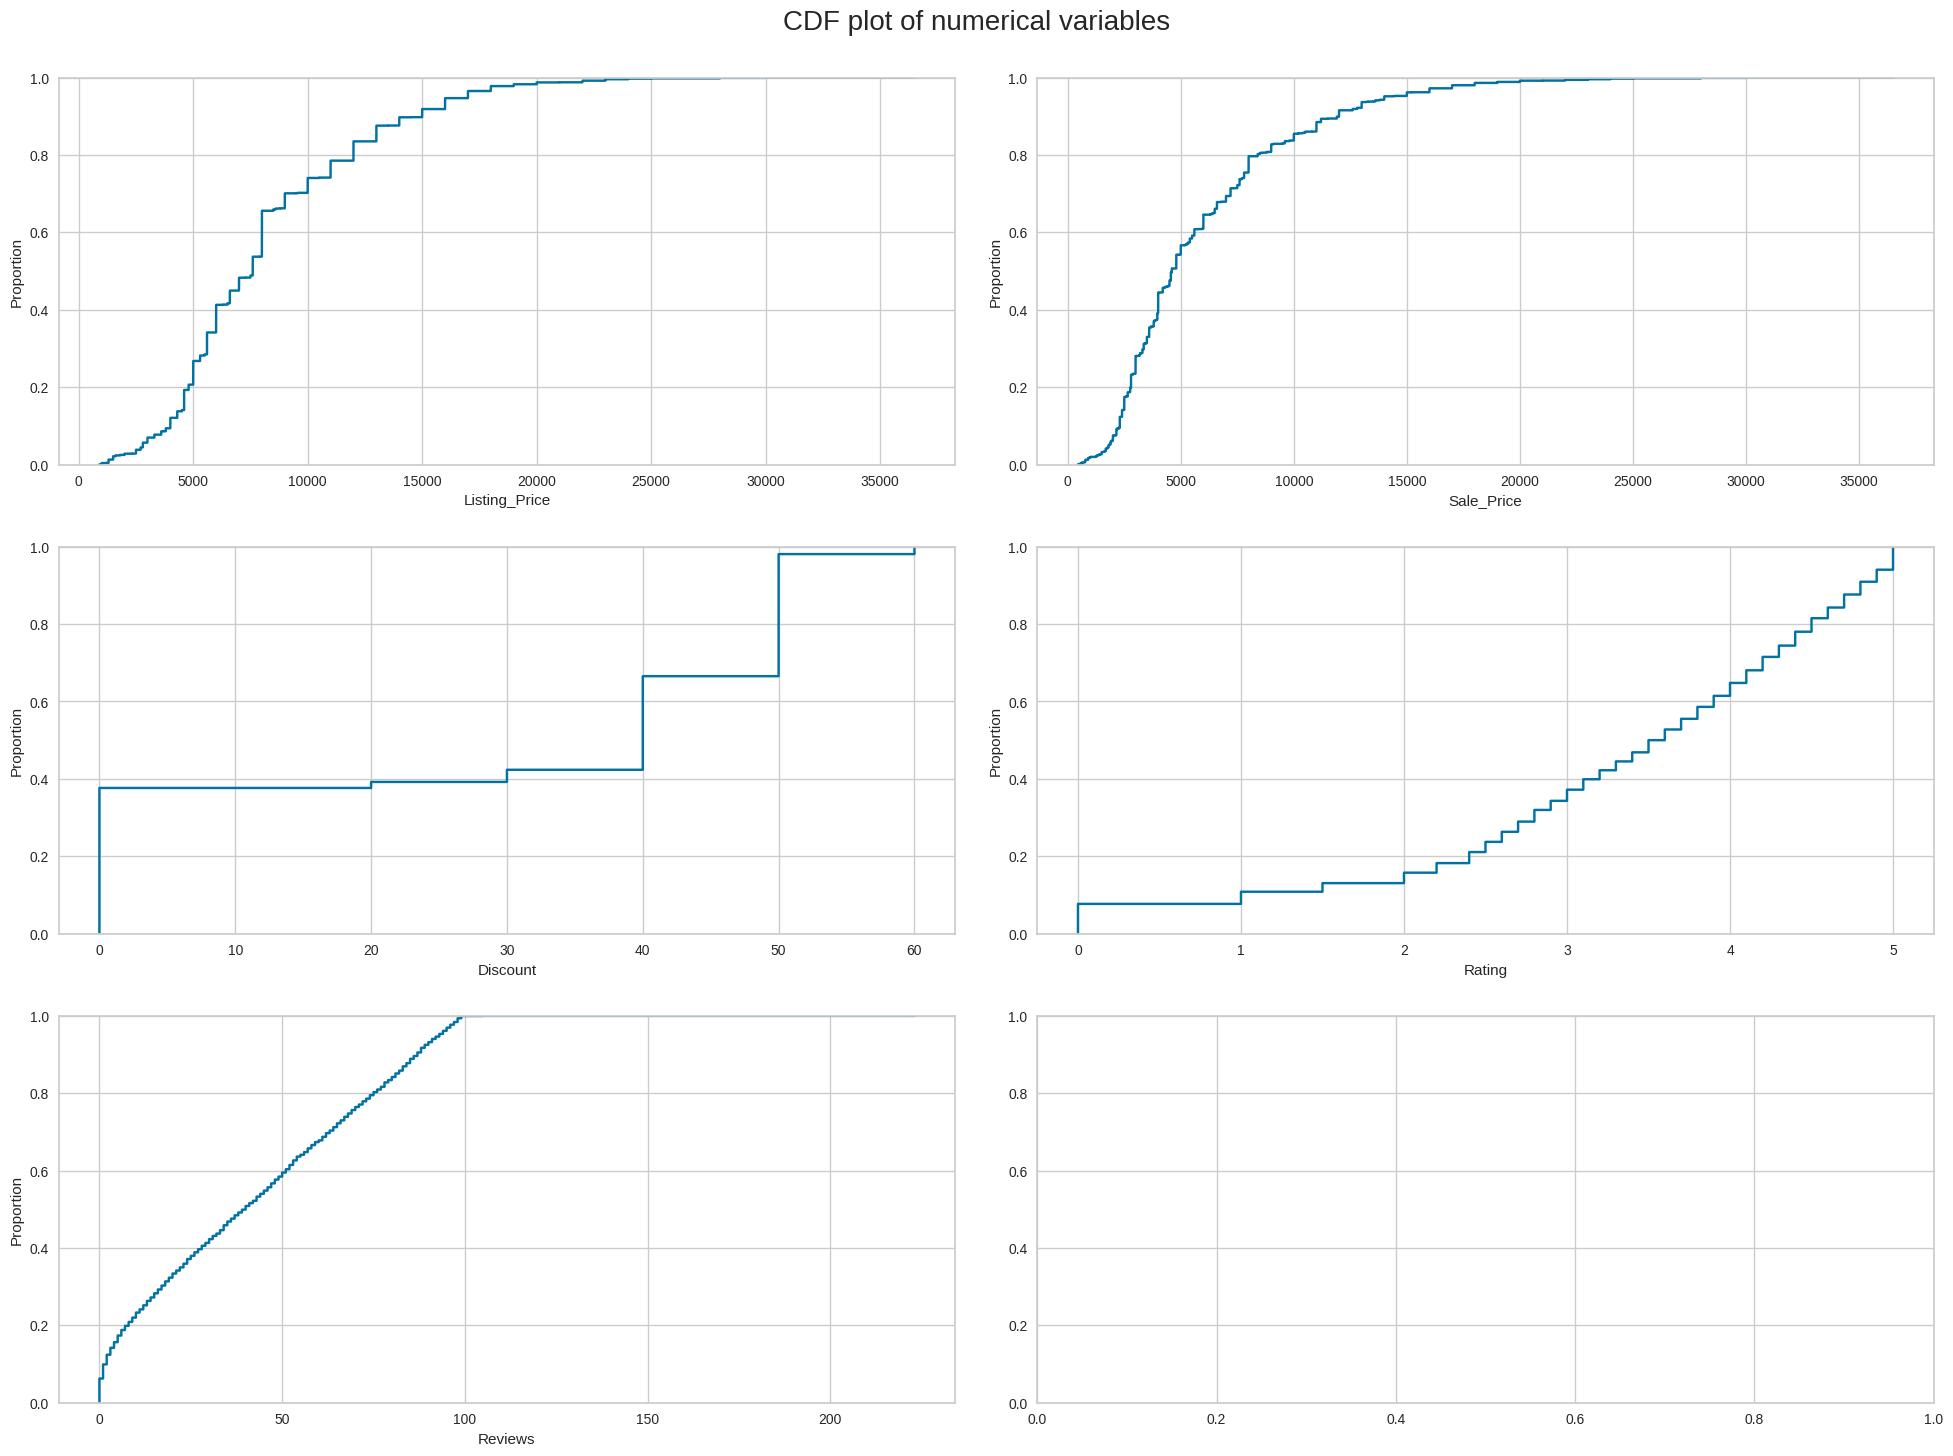

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

**Observations**

- 90% of the products have listing prices less than 15000.
- 95% of the product have a sale price of less than 15000.
- 80% of the products have at least 50% discount or less than 50%.
- 50% off the products have a rating of 3.5 or less than 3.5.
- Almost all products have 100 or fewer reviews.

In [23]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

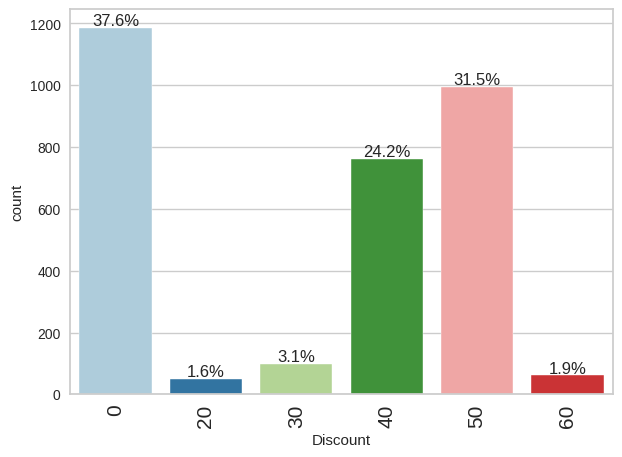

In [24]:
# let's explore discounts further
labeled_barplot(df, "Discount", perc=True)

**Observations**

- 37.6% of products did not have any discounts.
- More than 50% of the products have 40-50% discount.

## Bivariate Analysis

**Let's check for correlations.**

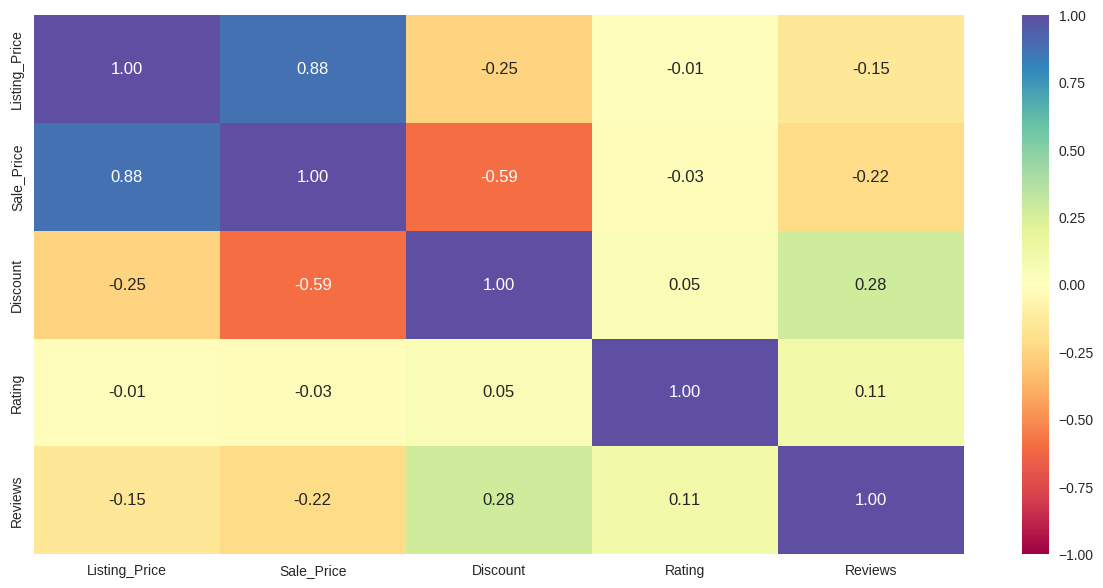

In [25]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations**

- The sale price and the listing price are highly positively correlated, which is obvious.
- Discount is somewhat negatively correlated with listing price or sale price, which indicates that expensive products either have fewer discounts or no discounts at all.

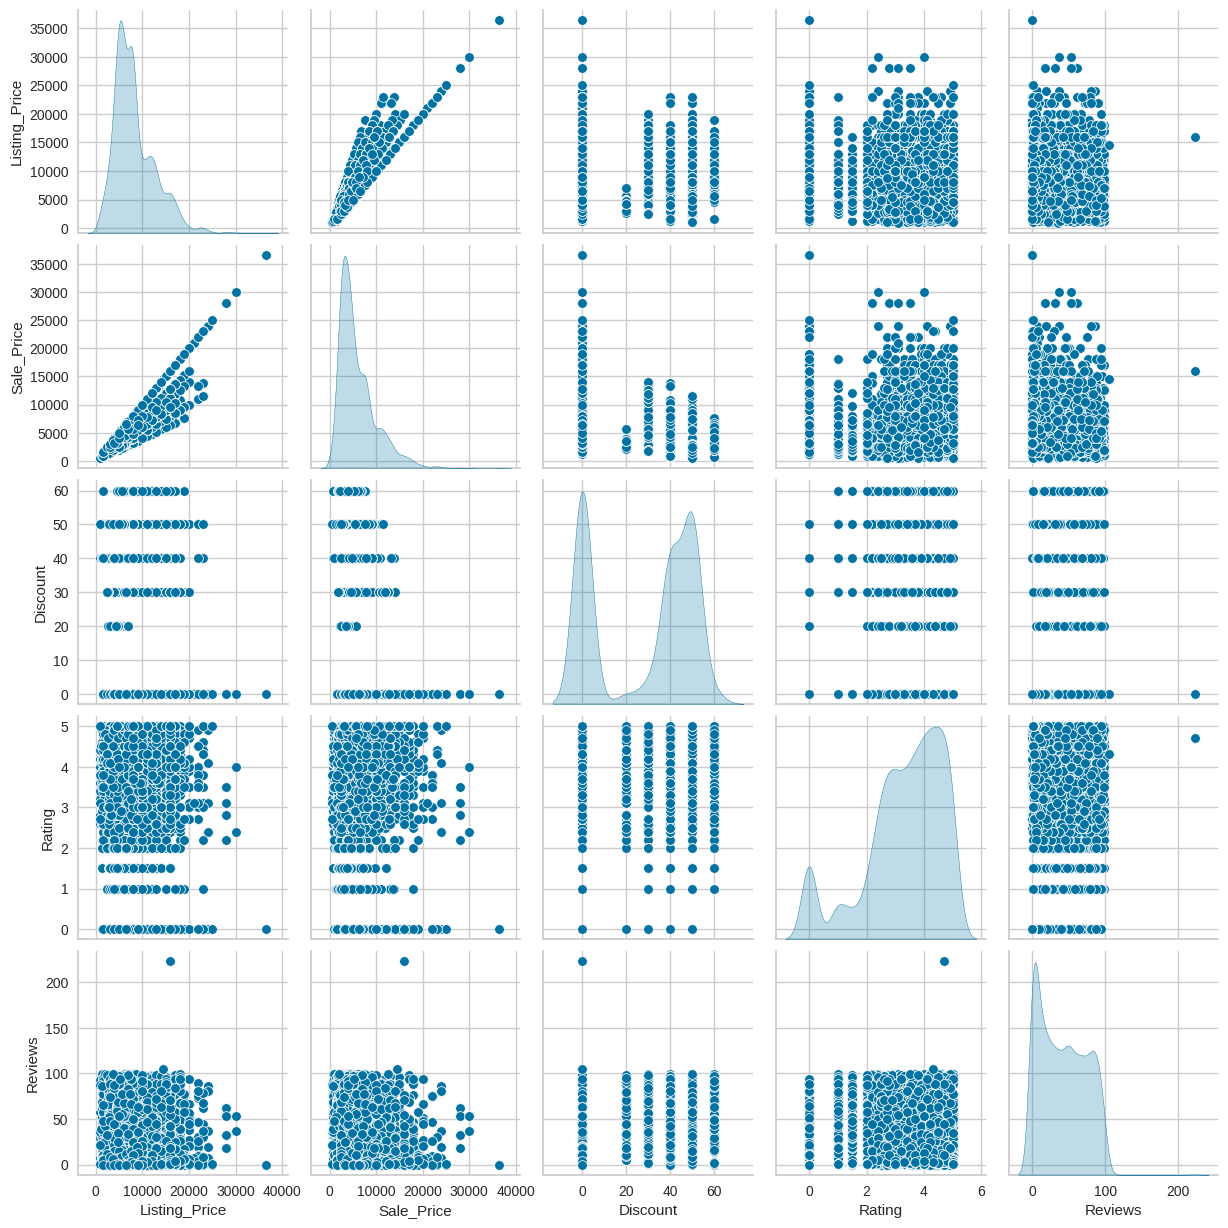

In [26]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**

- 50-60% discounts are mostly given to products whose listing price is 10,000 or less.
- Many products have no discount.
- As seen before, most of the products have 100 or fewer reviews.

## Data Preprocessing

In [27]:
# variables used for clustering
num_col

['Listing_Price', 'Sale_Price', 'Discount', 'Rating', 'Reviews']

In [28]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [29]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 1 	Average Distortion: 2.090721100645825


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 2 	Average Distortion: 1.712012896274925


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 3 	Average Distortion: 1.555521478926981


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 4 	Average Distortion: 1.4456582230533404


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 5 	Average Distortion: 1.308322058910372


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 6 	Average Distortion: 1.2304343122415113


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 7 	Average Distortion: 1.1692373321958645


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 8 	Average Distortion: 1.1009710901209453


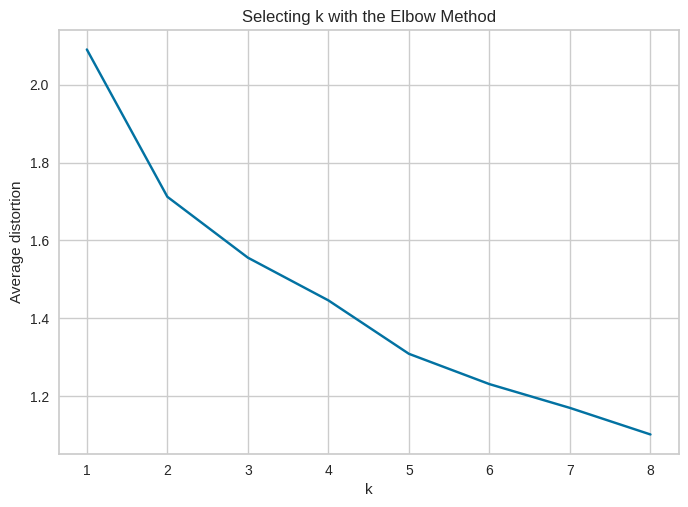

In [30]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

**Appropriate value for k seems to be 3 or 4.**

**Let's check the silhouette scores.**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2, the silhouette score is 0.33477783024101243)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3, the silhouette score is 0.2974433054771778)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4, the silhouette score is 0.30648807651929344)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5, the silhouette score is 0.27039882323409675)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6, the silhouette score is 0.2813115793502848)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7, the silhouette score is 0.2908564631266205)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8, the silhouette score is 0.29280090872818937)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9, the silhouette score is 0.2859304732353153)


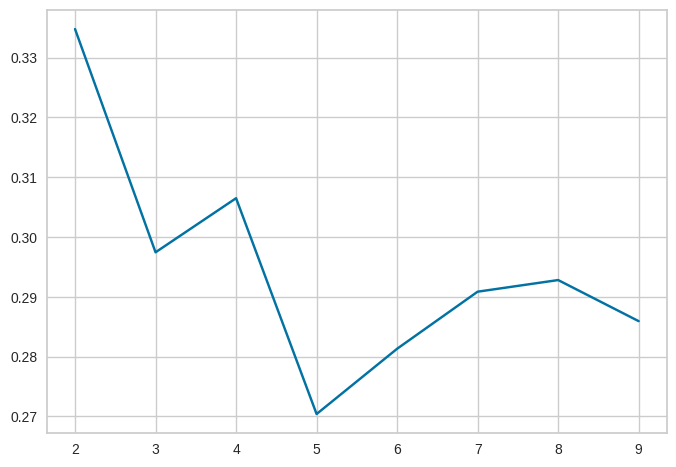

In [31]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

**Silhouette score for 4 is higher than that for 3. So, we will choose 4 as value of k.**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


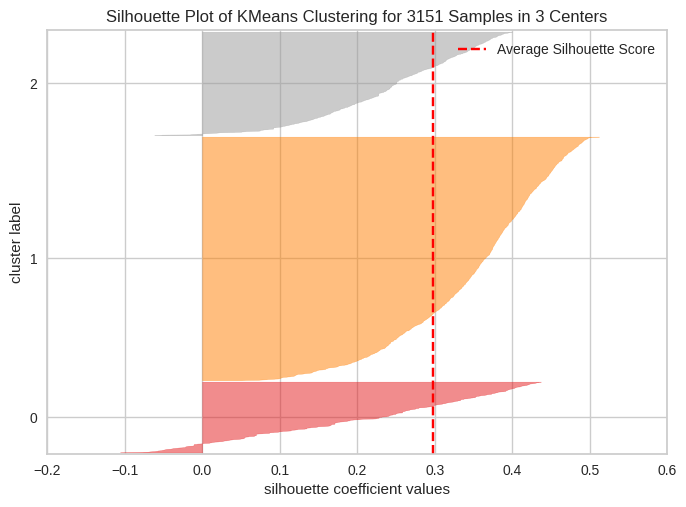

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3151 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


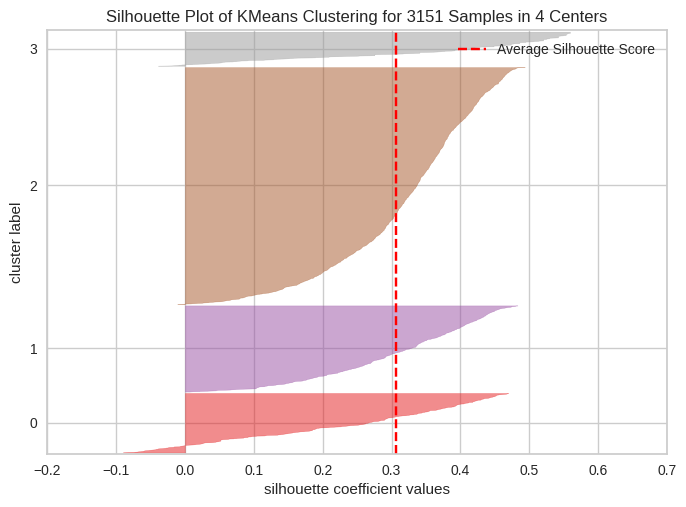

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3151 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

In [34]:
# let's take 4 as number of clusters
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=0)

In [35]:
# adding kmeans cluster labels to the original and scaled dataframes
df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

## Cluster Profiling

In [36]:
cluster_profile = df.groupby("K_means_segments").mean()

<ipython-input-36-695933a42b1b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_profile = df.groupby("K_means_segments").mean()


In [37]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("K_means_segments")["Sale_Price"].count().values
)

In [38]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Listing_Price,Sale_Price,Discount,Rating,Reviews,count_in_each_segments
K_means_segments,,,,,,
0,15557.331111,13424.604444,8.711111,3.928444,31.780000,450
1,6804.826331,3688.977031,45.462185,3.390924,50.151261,1785
2,9725.996255,8331.101124,7.715356,0.255805,11.898876,267
3,6505.070878,6167.425270,1.016949,3.797072,38.522342,649


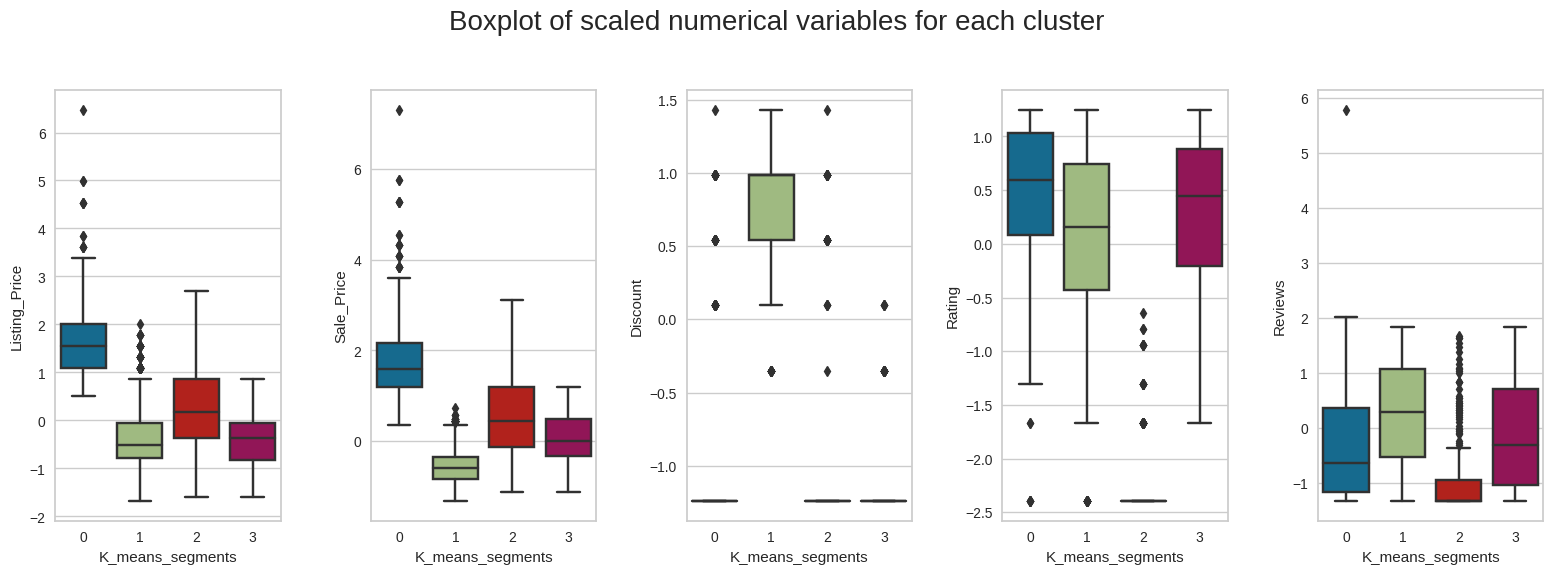

In [39]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

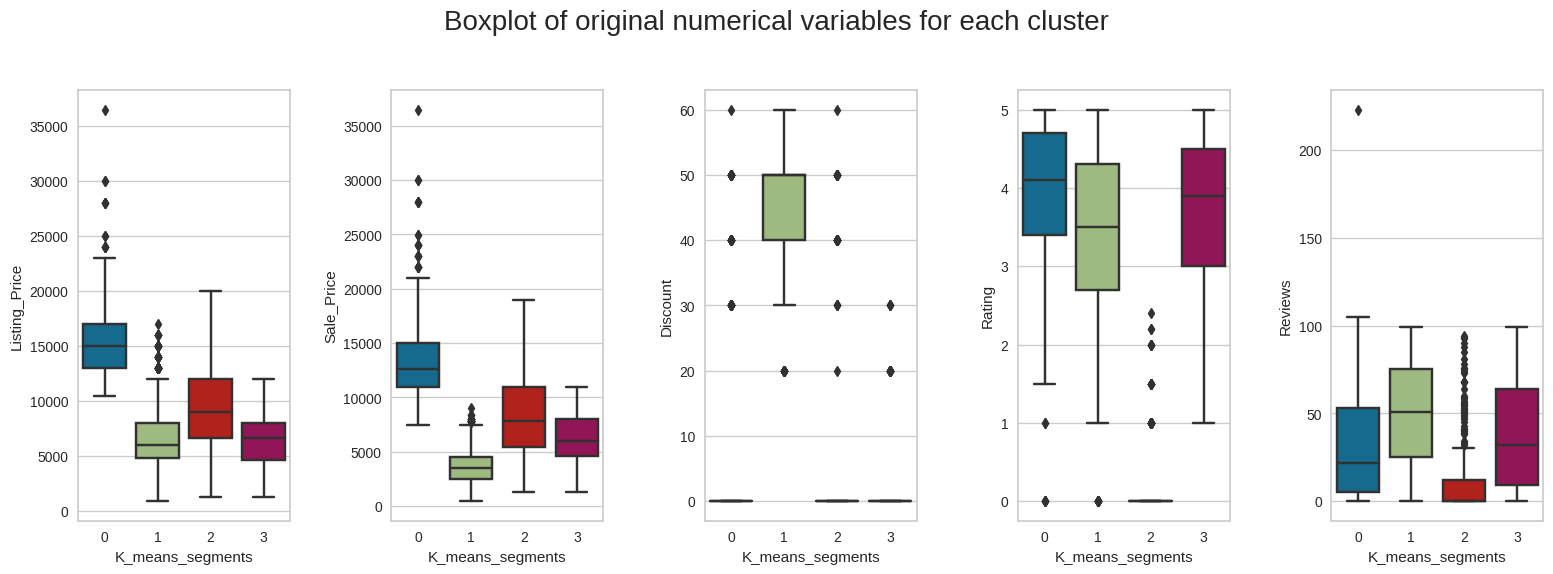

In [40]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Insights

- **Cluster 0**:
    - This cluster contains more expensive premium products, with an average listing price of approximately 15500.
    - Almost no discount is given to products in this cluster.
    - The median rating of this cluster is around 4 suggesting that customers are very satisfied with 50% of the products in this cluster.
    - Products in these clusters have got lesser reviews, which can be because these products are very expensive and fewer people buy them.
   
- **Cluster 1**:
    - Listing price is low for products in this cluster, and the sale price is lower, as there are heavier discounts on these products.
    - 50% of the products have discounts between 30% to 40%.
    - More than 50% of products have a rating from 2.5 to 4.5 which indicates that customer satisfaction varies across products in this cluster.
    - On average, 50 reviews are given to products in this cluster.
    
- **Cluster 2**:
    - The listing price of products in this cluster is similar to those in Cluster 1, but the sale price is comparatively higher as there are almost no discounts.
    - On average, 38 reviews are given to products in this cluster.


- **Cluster 3**:
    - Listing and sale price of products in this cluster suggest that these are medium-range products.
    - Almost no discount is given to products in this cluster.
    - Products in this cluster have a low rating or no rating at all.

**Let's compare Cluster vs Brand**

In [41]:
pd.crosstab(df.K_means_segments, df.Brand).style.highlight_max(
    color="lightgreen", axis=0
)

Brand,Adidas Adidas ORIGINALS,Adidas CORE / NEO,Adidas ORIGINALS,Adidas SPORT PERFORMANCE,Nike
K_means_segments,,,,,
0,0,0,133,128,189
1,1,864,564,356,0
2,0,18,53,23,173
3,0,229,156,99,165


**Observations**

- Adidas gives more discounts on their products, while Nike barely gives any.
- Nearly one-third of Nike products are premium in nature.

## Business Recommendations

- Cluster 0 consists of premium products, so focused marketing campaigns can be done to target customers with higher purchasing power.
- Cluster 0 products can also be made available in showrooms situated in premium locations because people generally tend to buy premium products from showrooms.
- Cluster 1 consists of products that are sold at higher discounts, so these might be the ones that are introduced in large quantity during festive sales (like Christmas, Black Friday, New Year, etc). This strategy can be continued with high inventory.
- Cluster 2 and 3 consists of products with comparatively low and medium prices with almost no discount, so general marketing campaigns can be done for these to target the general public.